# **NYC Restaurant Inspections Processing**

Joe Lardie

September 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder

#Scipy
from scipy import stats
from scipy.stats import norm

#Sklearn Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
set_config(display = 'diagram')

In [2]:
#Necesary installs to run notebook
#pip install nltk
#pip install wordcloud
#nltk.download('stopwords')

# **Data Dictionary**
**DBA**	This field represents the name (doing business as) of the entity (restaurant); Public business name, may change at discretion of restaurant owner

**BORO**	Borough in which the entity (restaurant) is located.;• 1 = MANHATTAN • 2 = BRONX • 3 = BROOKLYN • 4 = QUEENS • 5 = STATEN ISLAND • Missing; NOTE: There may be discrepancies between zip code and listed boro due to differences in an establishment's mailing address and physical location

**BUILDING**  Building number for establishment (restaurant) location

**STREET**	Street name for establishment (restaurant) location

**ZIPCODE**	Zip code of establishment (restaurant) location

**PHONE**	Phone Number; Phone number provided by restaurant owner/manager

**CUISINE DESCRIPTION**	This field describes the entity (restaurant) cuisine. ; Optional field provided by provided by restaurant owner/manager

**INSPECTION DATE**	This field represents the date of inspection; NOTE: Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection

**ACTION**	This field represents the actions that is associated with each restaurant inspection. ; • Violations were cited in the following area(s). • No violations were recorded at the time of this inspection. • Establishment re-opened by DOHMH • Establishment re-closed by DOHMH • Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed. • "Missing" = not yet inspected;

**VIOLATION CODE**	Violation code associated with an establishment (restaurant) inspection

**VIOLATION DESCRIPTION**Violation description associated with an establishment (restaurant) inspection

**CRITICAL FLAG**	Indicator of critical violation; "• Critical • Not Critical • Not Applicable"; Critical violations are those most likely to contribute to food-borne illness

**SCORE**Total score for a particular inspection; Scores are updated based on adjudication results

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

**GRADE DATE**	The date when the current grade was issued to the entity (restaurant)

**RECORD DATE**	The date when the extract was run to produce this data set

**INSPECTION TYPE** A combination of the inspection program and the type of inspection performed; See Data Dictionary for full list of expected values


## **Important Context**

RECORD DATE = (date of the data pull).

Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.

Establishments are uniquely identified by their CAMIS (record ID) number.

# **Import Data**

In [3]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [4]:
# Glance of inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205586 entries, 0 to 205585
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  205586 non-null  int64  
 1   DBA                    205122 non-null  object 
 2   BORO                   205586 non-null  object 
 3   BUILDING               205200 non-null  object 
 4   STREET                 205582 non-null  object 
 5   ZIPCODE                202881 non-null  float64
 6   CUISINE DESCRIPTION    203371 non-null  object 
 7   INSPECTION DATE        205586 non-null  object 
 8   ACTION                 203371 non-null  object 
 9   VIOLATION CODE         202237 non-null  object 
 10  VIOLATION DESCRIPTION  202237 non-null  object 
 11  CRITICAL FLAG          205586 non-null  object 
 12  SCORE                  196136 non-null  float64
 13  GRADE                  101750 non-null  object 
 14  GRADE DATE             92110 non-nul

- Grade date has the fewest amount of values

# **Data Cleaning**

### **Function to clean up names**

In [7]:
# Function to clean restaurant names
def clean_restaurant_name(name):
    # Check if the input is a string
    if isinstance(name, str):
        # Remove store numbers using regular expression
        cleaned_name = re.sub(r'#\d+', '', name)
        
        # Remove all numeric characters
        cleaned_name = re.sub(r'\d+', '', cleaned_name)
    
        # Remove leading and trailing whitespace
        cleaned_name = cleaned_name.strip()
    
        return cleaned_name
    else:
        return name  # Return the input unchanged for non-string values

# Apply the clean_restaurant_name function to the 'DBA' column
rdf['Cleaned Restaurant Name'] = rdf['DBA'].apply(clean_restaurant_name)

# Drop the original 'DBA' column if you want
#df.drop(columns=['DBA'], inplace=True)

In [48]:
rdf['DBA'].value_counts()

DUNKIN                   2529
SUBWAY                   1505
STARBUCKS                1130
MCDONALD'S               1019
KENNEDY FRIED CHICKEN     696
                         ... 
RELAX                       1
AMZ JFK27 EBC               1
Mr Paris Catering Inc       1
DONER WISE HOUSE            1
HOTEL 42                    1
Name: DBA, Length: 21989, dtype: int64

In [44]:
# checking missing data in data 
def check_missing_data(rdf):
    total = rdf.isnull().sum().sort_values(ascending = False)
    percent = (rdf.isnull().sum()/rdf.isnull().count()*100).sort_values(ascending = False)
    percent = percent.round(2).astype(str) + '%'
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(rdf)
missing_data.head(20)

,Total,Percent
GRADE DATE,113476,55.196366
GRADE,103836,50.507330
SCORE,9450,4.596617
VIOLATION DESCRIPTION,3349,1.629002
VIOLATION CODE,3349,1.629002
Council District,3323,1.616355
ZIPCODE,2705,1.315751
INSPECTION TYPE,2215,1.077408
CUISINE DESCRIPTION,2215,1.077408
ACTION,2215,1.077408


Grade, Score, and Grade date - missing a lot of data due to some places not yet receiving an inspection
DBA needs to reference CAMIS to ensure the situation surrounding the repeated rows
Inspection Type may be related to places not yet received an inspection


In [49]:
# Checking for duplicates
rdf.duplicated().sum()

6

In [10]:
rdf['SCORE'].describe()

count    196136.000000
mean         22.586231
std          17.431783
min           0.000000
25%          11.000000
50%          18.000000
75%          30.000000
max         168.000000
Name: SCORE, dtype: float64

This should mean that there are 21,920 different restaurants

In [11]:
rdf['CAMIS'].value_counts()

40398688    65
50045647    56
40365904    52
41406895    50
50111296    49
            ..
50101813     1
50127531     1
50116203     1
50123429     1
50117386     1
Name: CAMIS, Length: 28033, dtype: int64

This should mean that there are 27960 total different restaurants inspected

In [12]:
rdf['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          112959
Cycle Inspection / Re-inspection                                36080
Pre-permit (Operational) / Initial Inspection                   30463
Pre-permit (Operational) / Re-inspection                         9085
Administrative Miscellaneous / Initial Inspection                4756
Pre-permit (Non-operational) / Initial Inspection                2447
Pre-permit (Operational) / Compliance Inspection                 1513
Cycle Inspection / Reopening Inspection                          1415
Administrative Miscellaneous / Re-inspection                      930
Pre-permit (Operational) / Reopening Inspection                   711
Cycle Inspection / Compliance Inspection                          687
Smoke-Free Air Act / Initial Inspection                           548
Trans Fat / Initial Inspection                                    381
Inter-Agency Task Force / Initial Inspection                      339
Calorie Posting / In

In [13]:
# Looking at different Restaurant Types, Potential to filter out specific types for geospacial analysis
all_unique_values = rdf['CUISINE DESCRIPTION'].unique()
print(all_unique_values)

['Coffee/Tea' 'American' 'Mediterranean' 'Korean' 'Frozen Desserts'
 'Tex-Mex' 'Thai' nan 'Chinese' 'Other' 'Juice, Smoothies, Fruit Salads'
 'Soul Food' 'Middle Eastern' 'Latin American' 'Mexican' 'Chicken'
 'Italian' 'Greek' 'Pizza' 'Donuts' 'Jewish/Kosher' 'Bagels/Pretzels'
 'African' 'Bakery Products/Desserts' 'Eastern European' 'Caribbean'
 'Japanese' 'Soups/Salads/Sandwiches' 'Spanish' 'Irish' 'Seafood' 'Indian'
 'Bottled Beverages' 'Sandwiches/Salads/Mixed Buffet' 'English'
 'Chinese/Japanese' 'Peruvian' 'Steakhouse' 'Sandwiches' 'Hamburgers'
 'Portuguese' 'Asian/Asian Fusion' 'Barbecue' 'French' 'Salads'
 'Vegetarian' 'Bangladeshi' 'Hotdogs' 'Southeast Asian' 'Tapas'
 'Pancakes/Waffles' 'Turkish' 'Hotdogs/Pretzels' 'Russian' 'Fusion'
 'Continental' 'Pakistani' 'Filipino' 'New American' 'Vegan'
 'Nuts/Confectionary' 'New French' 'Not Listed/Not Applicable'
 'Chinese/Cuban' 'Scandinavian' 'Brazilian' 'Afghan' 'Polish' 'Indonesian'
 'Australian' 'Lebanese' 'Hawaiian' 'Creole' 'Bas

## **Grade Date by Year**

In [14]:
# Convert the 'GRADE DATE' column to datetime type
rdf['GRADE DATE'] = pd.to_datetime(rdf['GRADE DATE'])

# Filter rows for the year 2016
desired_year = 2016 
filtered_df = rdf[rdf['GRADE DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df)

           CAMIS                          DBA       BORO BUILDING  \
464     41395403         CITI FIELD STAND 137     Queens      000   
613     41564945        RADIO CITY MUSIC HALL  Manhattan     1260   
726     41395517     CITI FIELD PRESS KITCHEN     Queens      000   
1087    41395380         CITI FIELD STAND 112     Queens      000   
2203    50035307         RAZOR'S BAR & LOUNGE   Brooklyn       87   
...          ...                          ...        ...      ...   
202348  50052205                 TERRACE EAST   Brooklyn     3052   
203188  50015536            STUDIO 54 THEATRE  Manhattan      254   
203399  41395427         CITI FIELD STAND 421     Queens      000   
204426  41468415                    ARABESQUE  Manhattan        4   
205288  41395378  CITI FIELD STERLING KITCHEN     Queens      000   

                              STREET  ZIPCODE CUISINE DESCRIPTION  \
464      126TH ST & ROOSEVELT AVENUE      NaN            American   
613           AVENUE OF THE AMERI

2016 = 293

2017 = 934

2018 = 1358

2019 = 6832

2020 = 5339

2021 = 7878

2022 = 38820

2023 = 30296

## **Inspection Date by Year**

2016 = 483

2017 = 1578

2018 = 2340

2019 = 13033

2020 = 10562

2021 = 20800

2022 = 88263

2023 = 65539

In [15]:
# Convert the 'GRADE DATE' column to datetime type
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'])

# Filter rows for the year 2016
desired_year = 2023
filtered_df = rdf[rdf['INSPECTION DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df)

           CAMIS                                            DBA  \
1       50138009                              Rent Money Lounge   
4       50017993                                         CARVEL   
11      50065278                                          FERNS   
12      50134463                                PARRILLA LATINA   
13      40365904                                   MEE SUM CAFE   
...          ...                                            ...   
205580  50134341  LIBRARY BAR AT SHERATON NEW YORK TIMES SQUARE   
205581  50049662                        NEW CARRIZAL RESTAURANT   
205582  50140001                          VAN LEEUWEN ICE CREAM   
205583  41582872          SLEEP NO MORE AT THE MCKITTRICK HOTEL   
205584  50101022                                         YIFANG   

                 BORO BUILDING            STREET  ZIPCODE CUISINE DESCRIPTION  \
1           Manhattan       85    STANTON STREET  10002.0            American   
4       Staten Island      280   

# **Visualizations**

# **Scores**

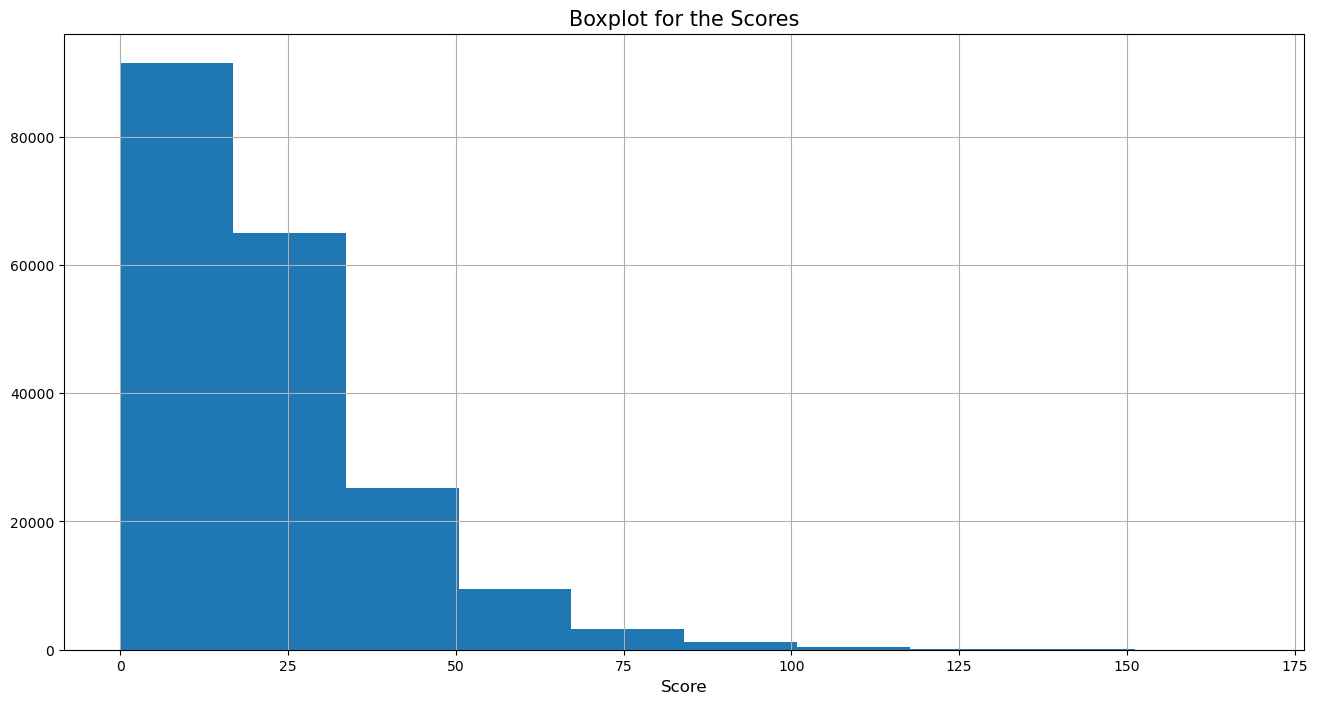

In [16]:
# Plot a histogram
rdf.SCORE.hist(figsize=(16,8))
plt.title("Boxplot for the Scores", fontsize=15)
plt.xlabel('Score', fontsize = 12);

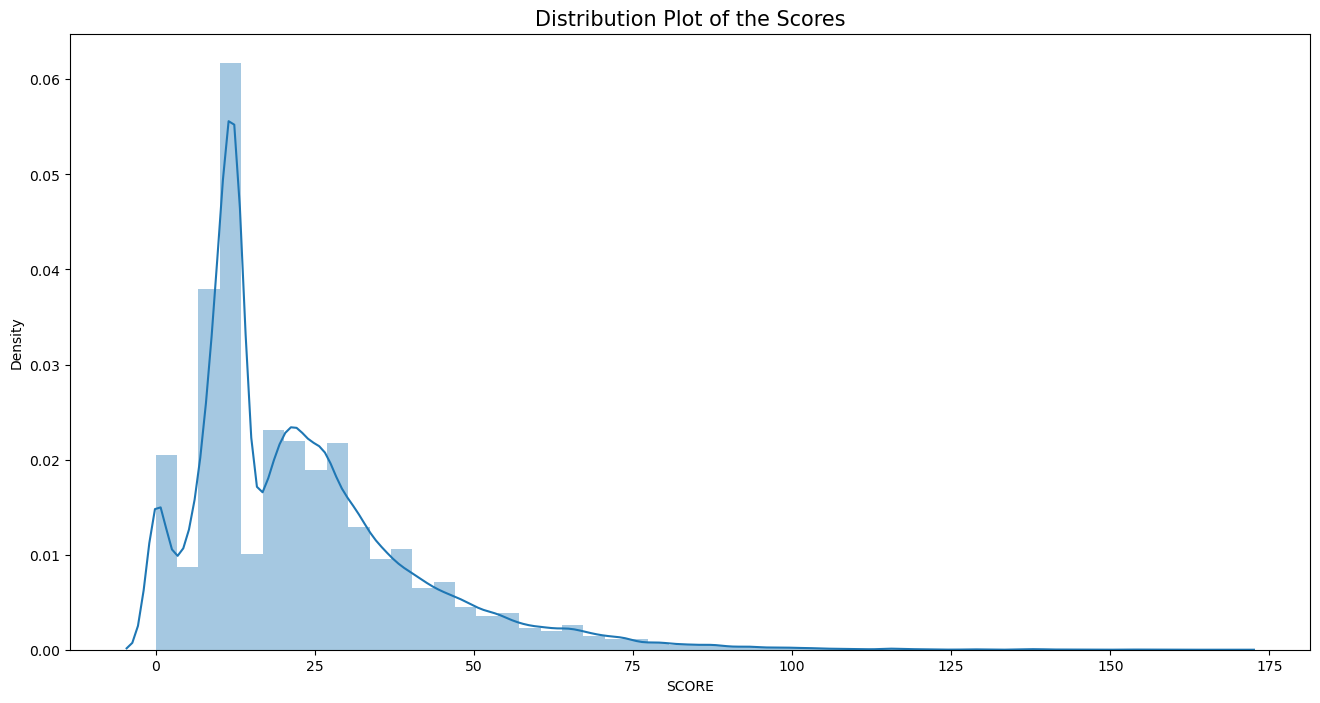

In [17]:
# Have a look at a distribution plot of the Score
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
sns.distplot(rdf.SCORE.dropna())
plt.title("Distribution Plot of the Scores", fontsize=15);

In [18]:
# Sort the DataFrame by the count of restaurants in descending order
#sorted_df = grouped_df.sort_values(by='CAMIS_Count', ascending=False)

# Select the top 15 DBAs
#top_15_df = sorted_df.head(15)

# Create a bar chart
#plt.figure(figsize=(12, 6))
#plt.bar(top_15_df['DBA'], top_15_df['CAMIS_Count'])
#plt.xlabel('DBA (Doing Business As)')
#plt.ylabel('Number of Restaurants')
#plt.title('Top 15 DBAs with the Most Restaurants')
#plt.xticks(rotation=90)
#plt.tight_layout()

# Show the plot
#plt.show()

## **NYC Boros**

### **Important Context:**

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

In [19]:
# Filter rows where 'BORO' is 0
f_df = rdf[rdf['BORO'] == '0']

# Display the filtered DataFrame
print(f_df)

           CAMIS                         DBA BORO BUILDING           STREET  \
312     50115885             PIZZA HUT 38746    0      760       FULTON AVE   
635     50123437                         NaN    0      274     ATLANTIC AVE   
735     50140778                         NaN    0      NaN              NaN   
1081    50127295                         NaN    0      247   HEMPSTEAD TPKE   
1133    50139597                         NaN    0      NaN              NaN   
16656   50141174              CHOMPS ELYSEES    0      NaN              NaN   
36036   50140500  TAIM MEDITERRANEAN KITCHEN    0      397  S OYSTER BAY RD   
92467   50140411  TAIM MEDITERRANEAN KITCHEN    0     1006   BROADHOLLOW RD   
115616  50141088                         NaN    0       23    PARK HILL AVE   
168997  50139890                         NaN    0      NaN              NaN   
170779  50126672                         NaN    0        2   SHADY BROOK LN   
181181  50128762                         NaN    0   

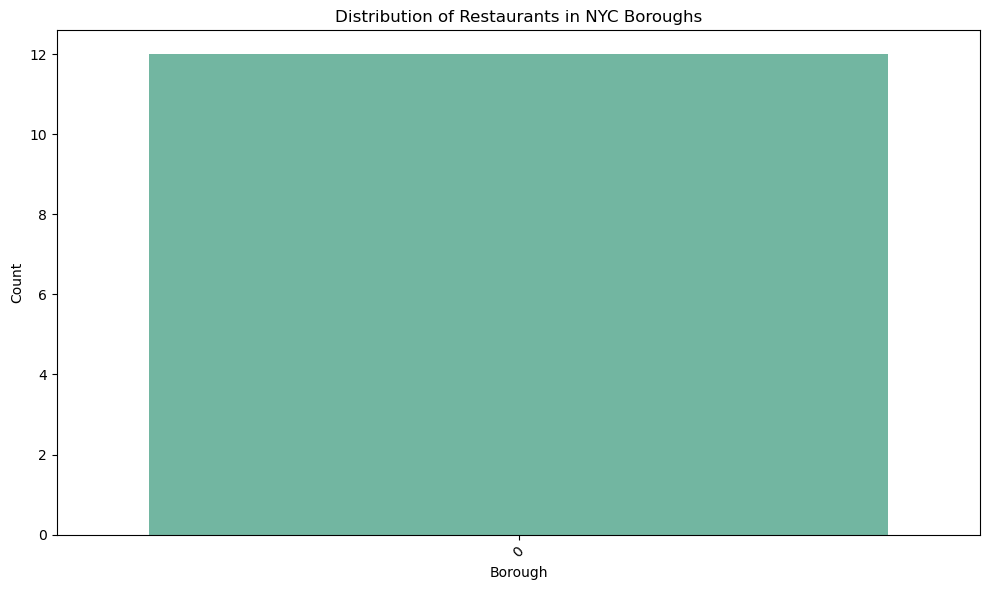

In [20]:
# Visualizing Distribution of Restaurants in NYC Boroughs
plt.figure(figsize=(10, 6))
sns.countplot(data=f_df, x='BORO', palette='Set2') 
plt.title('Distribution of Restaurants in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

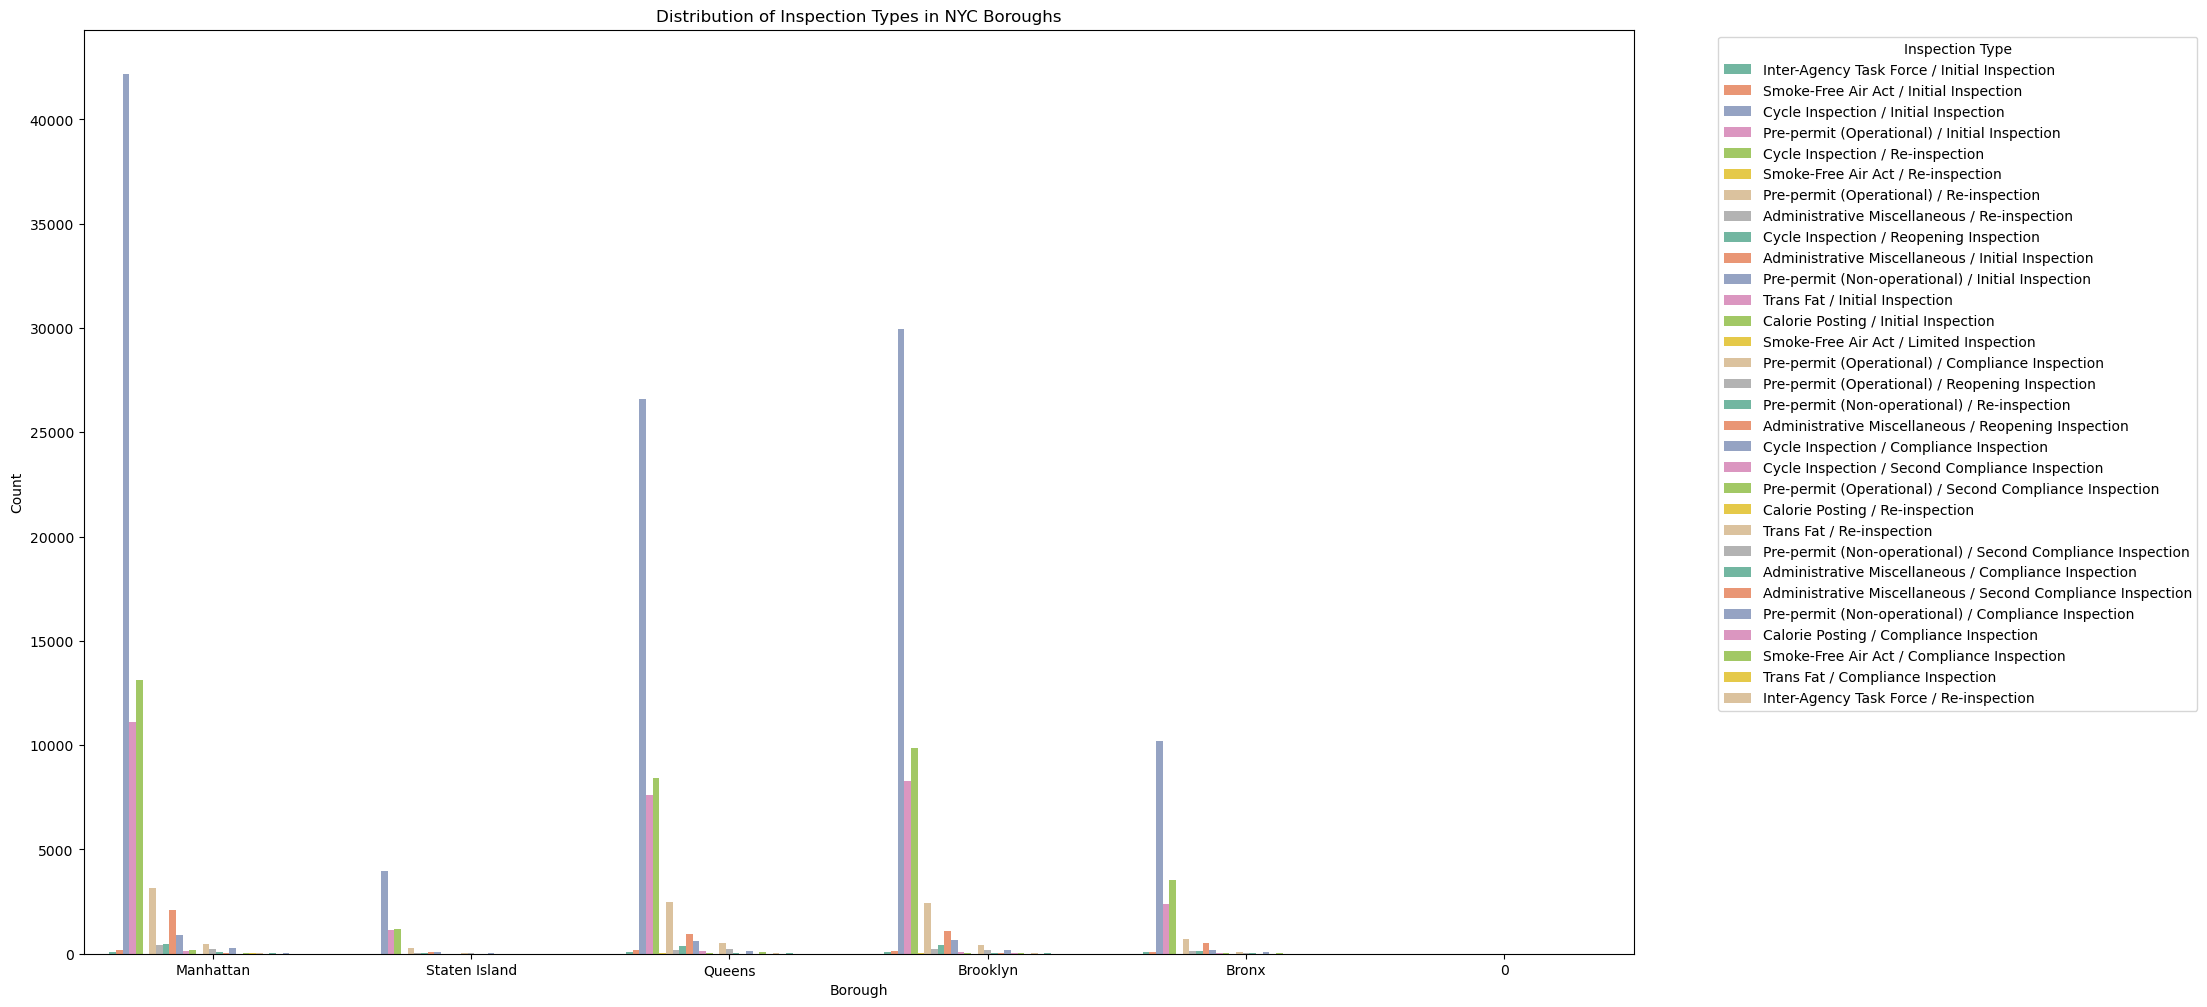

In [21]:
# Create a stacked bar chart using Seaborn
plt.figure(figsize=(20,12))
sns.countplot(x='BORO', hue='INSPECTION TYPE', data=rdf, palette='Set2')
plt.title('Distribution of Inspection Types in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')

# Show the plot
plt.legend(title='Inspection Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

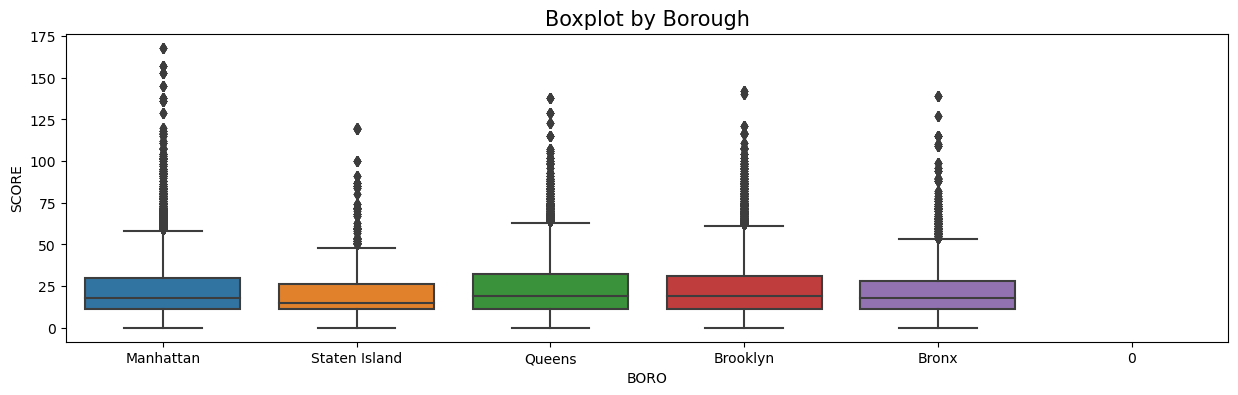

In [22]:
# Create a boxplot using Seaborn
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='BORO', y='SCORE', data=rdf)
plt.title('Boxplot by Borough', fontsize=15)

# Show the plot
plt.show()

In [23]:
# Contingency table for Grade and Borough
boro_grade = pd.crosstab(rdf.GRADE, rdf.BORO, margins = True)
boro_grade

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island,All
GRADE,,,,,,
A,6077,18283,26881,16553,2877,70671
B,1099,2932,3707,2698,370,10806
C,550,1663,2256,1664,115,6248
N,849,2293,3733,2430,346,9651
P,52,173,207,128,10,570
Z,430,850,1229,1160,135,3804
All,9057,26194,38013,24633,3853,101750


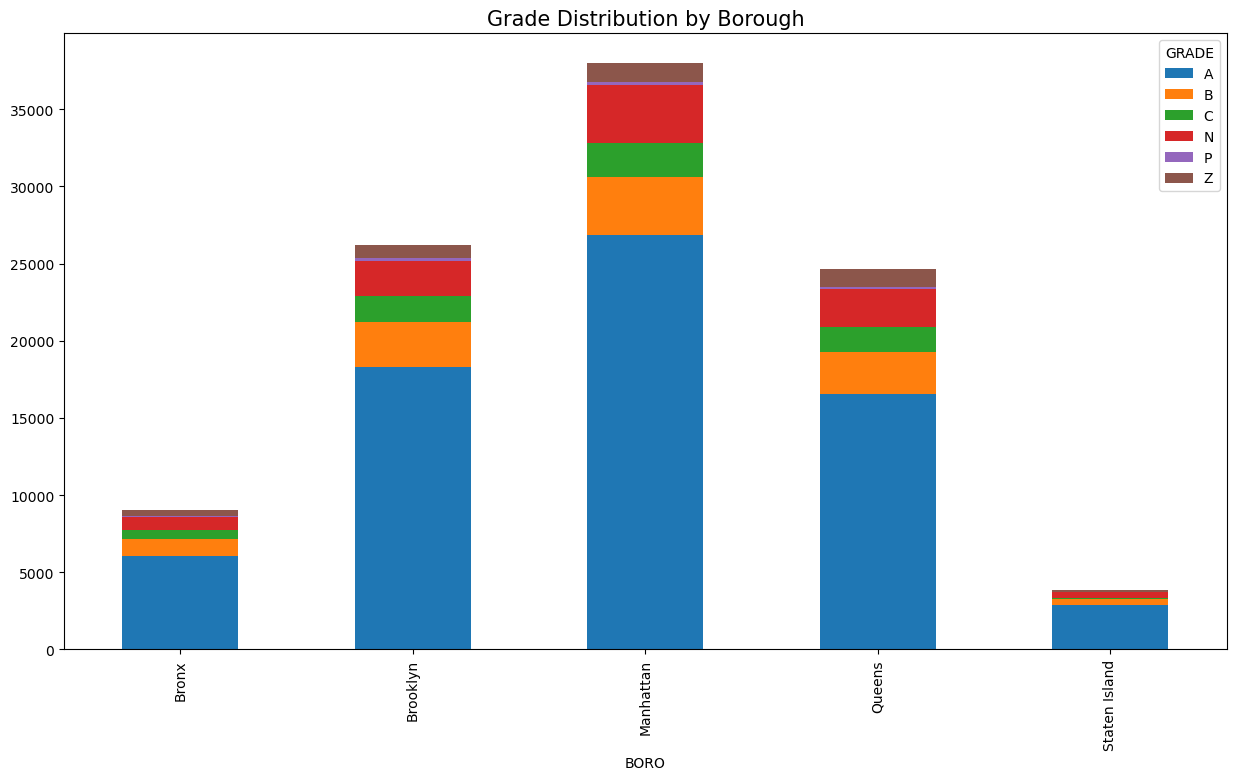

In [24]:
# Plot of grade by borough
pd.crosstab(rdf.BORO, rdf.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);

In [25]:
# Test if the grades are independent of the borough
boro_grade.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND" ,"All"]

boro_grade.index = ["A","B","C","Not Yet Graded","P", "Z", "All"]

observed = boro_grade.iloc[0:6,0:5]   # Get table without totals for later use

expected =  np.outer(boro_grade["All"][0:6],
                     boro_grade.loc["All"][0:5]) / 1000

expected = pd.DataFrame(expected)

expected.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND"]
expected.index = ["A","B","C","Not Yet Graded","P", "Z"]

chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print("Chi Squared Stat")
print(chi_squared_stat)

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 20)   # (5-1) * (6-1)

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=20)
print("P value")
print(p_value)

stats.chi2_contingency(observed= observed)

Chi Squared Stat
10150566.028508954
Critical value
31.410432844230918
P value
0.0


(359.02578612998184,
 6.135423300553942e-64,
 20,
 array([[6.29058719e+03, 1.81931811e+04, 2.64021300e+04, 1.71089803e+04,
         2.67612150e+03],
        [9.61866752e+02, 2.78184142e+03, 4.03703664e+03, 2.61606091e+03,
         4.09194280e+02],
        [5.56148757e+02, 1.60845319e+03, 2.33420368e+03, 1.51259935e+03,
         2.36595027e+02],
        [8.59057563e+02, 2.48450412e+03, 3.60553772e+03, 2.33644308e+03,
         3.65457523e+02],
        [5.07370025e+01, 1.46737887e+02, 2.12947518e+02, 1.37993219e+02,
         2.15843735e+01],
        [3.38602732e+02, 9.79282319e+02, 1.42114449e+03, 9.20923165e+02,
         1.44047292e+02]]))

## **Distribution of Grades**

Text(0.5, 1.0, 'Boxplot by Grade')

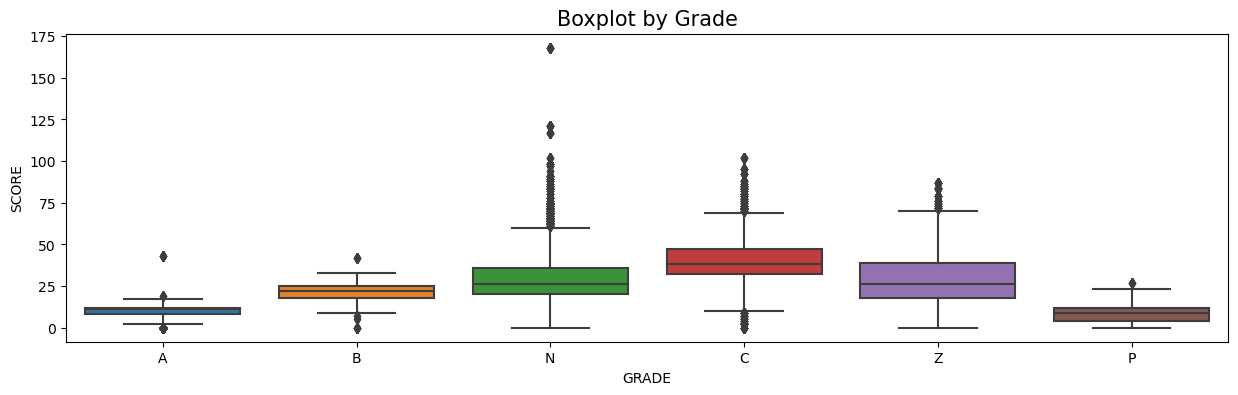

In [26]:
# Lets look at scores by grades with a Boxplot
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='GRADE', y='SCORE', data=rdf)
plt.title('Boxplot by Grade', fontsize = 15)

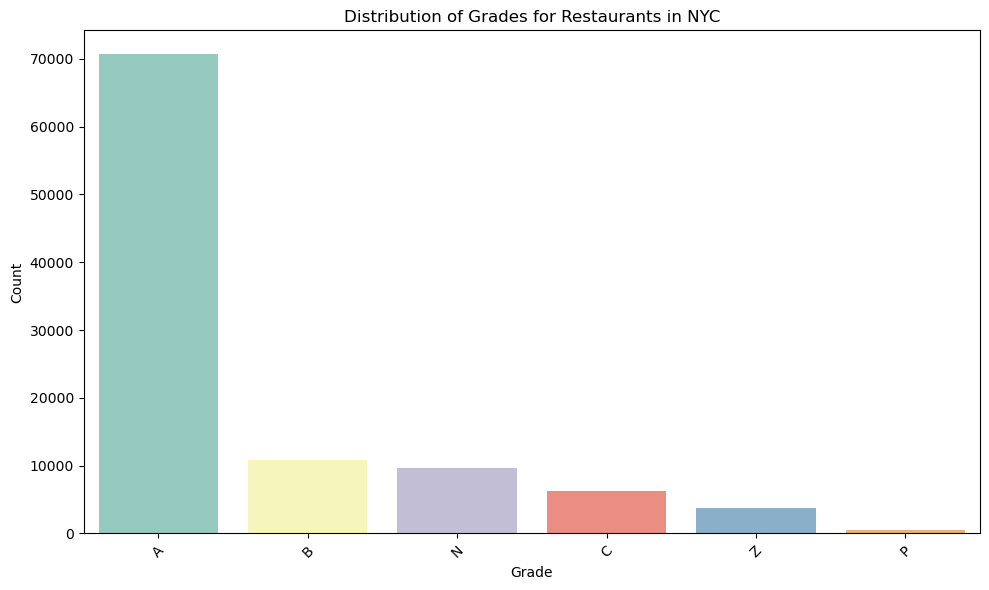

In [27]:
# Visualizing Distribution of Grades for Restaurants in NYC
plt.figure(figsize=(10, 6))
sns.countplot(data=rdf, x='GRADE', palette='Set3')  
plt.title('Distribution of Grades for Restaurants in NYC')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

## **Distribution of Cuisine Types**

In [28]:
# Filteriung out the irrelevant Cuisine Types for Visalization
min_cuisine_count = 1000
cuisine_counts = rdf['CUISINE DESCRIPTION'].value_counts()
filtered_cuisines = cuisine_counts[cuisine_counts >= min_cuisine_count].index
fdf = rdf[rdf['CUISINE DESCRIPTION'].isin(filtered_cuisines)]

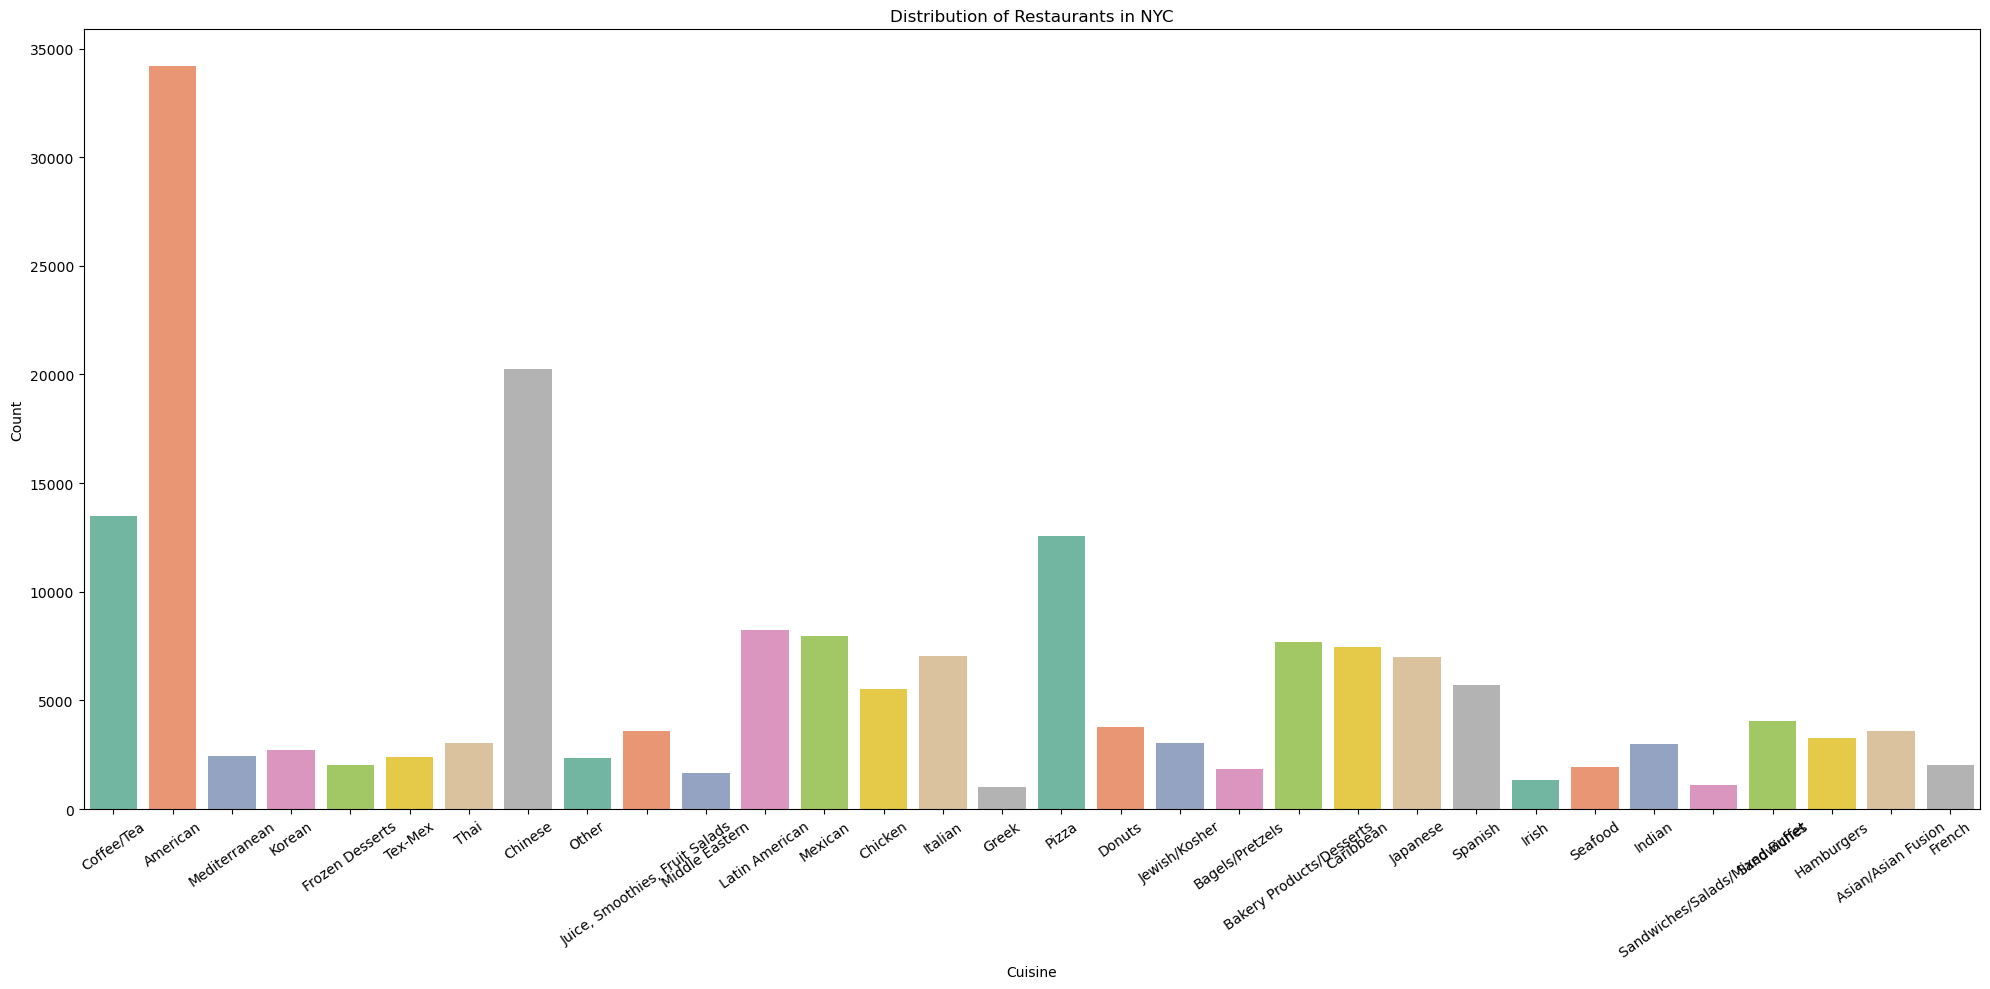

In [29]:
# Visualization of most popular cuisines
plt.figure(figsize=(20,10))
sns.countplot(data=fdf, x='CUISINE DESCRIPTION', palette='Set2') 
plt.title('Distribution of Restaurants in NYC')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=35) 

plt.tight_layout()
plt.show()

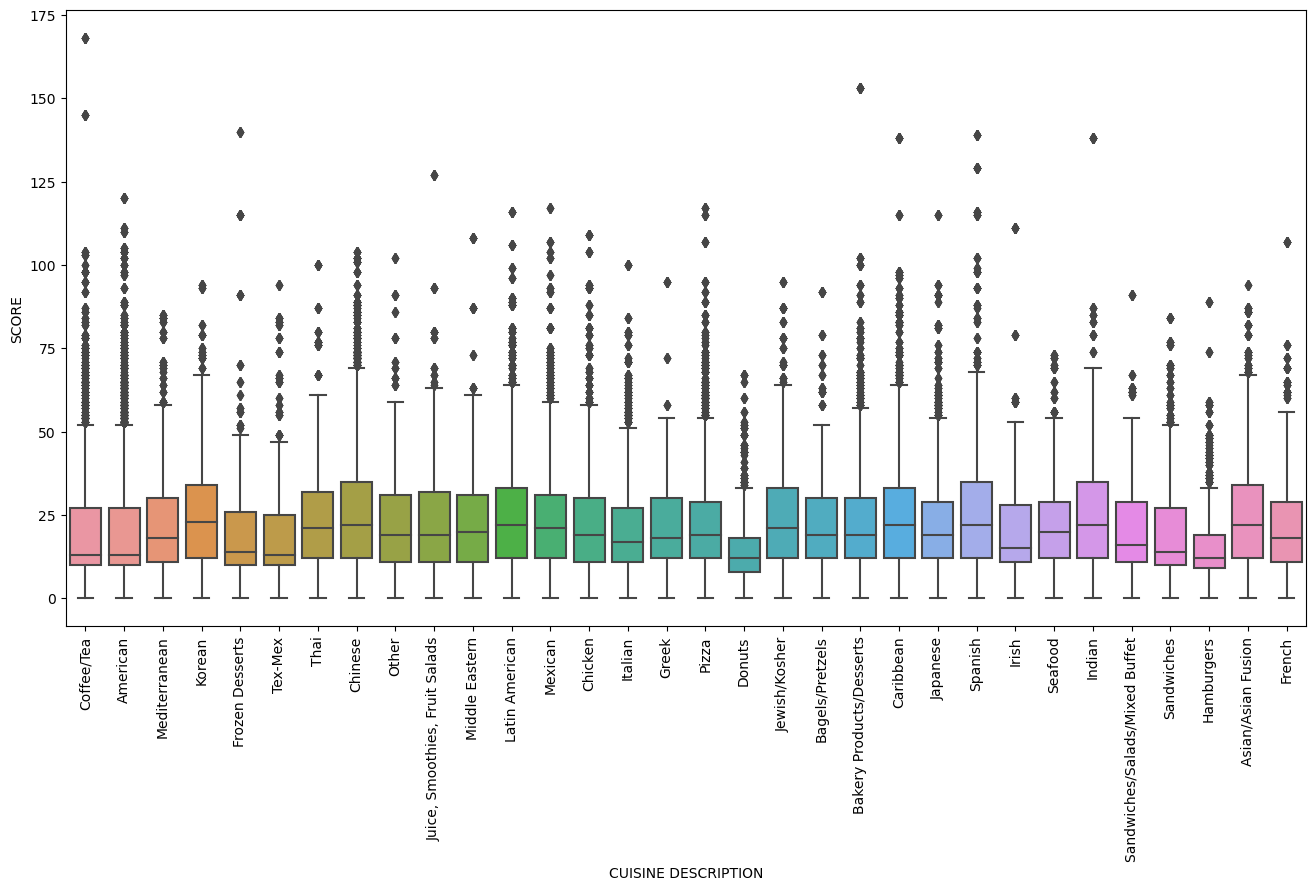

In [30]:
# Let us look at the scores by cuisine
score_cuisine = pd.concat([fdf['CUISINE DESCRIPTION'], fdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE DESCRIPTION', y="SCORE", data = fdf)
plt.xticks(rotation=90);

# **Action Analysis**

In [31]:
rdf.ACTION.value_counts()

Violations were cited in the following area(s).                                                                                       192565
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      7807
Establishment re-opened by DOHMH.                                                                                                       1857
No violations were recorded at the time of this inspection.                                                                             1138
Establishment re-closed by DOHMH.                                                                                                          4
Name: ACTION, dtype: int64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'No violations were recorded at the time of this inspection.'),
  Text(1, 0, 'Violations were cited in the following area(s).'),
  Text(2, 0, 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'),
  Text(3, 0, 'Establishment re-opened by DOHMH.'),
  Text(4, 0, 'Establishment re-closed by DOHMH.')])

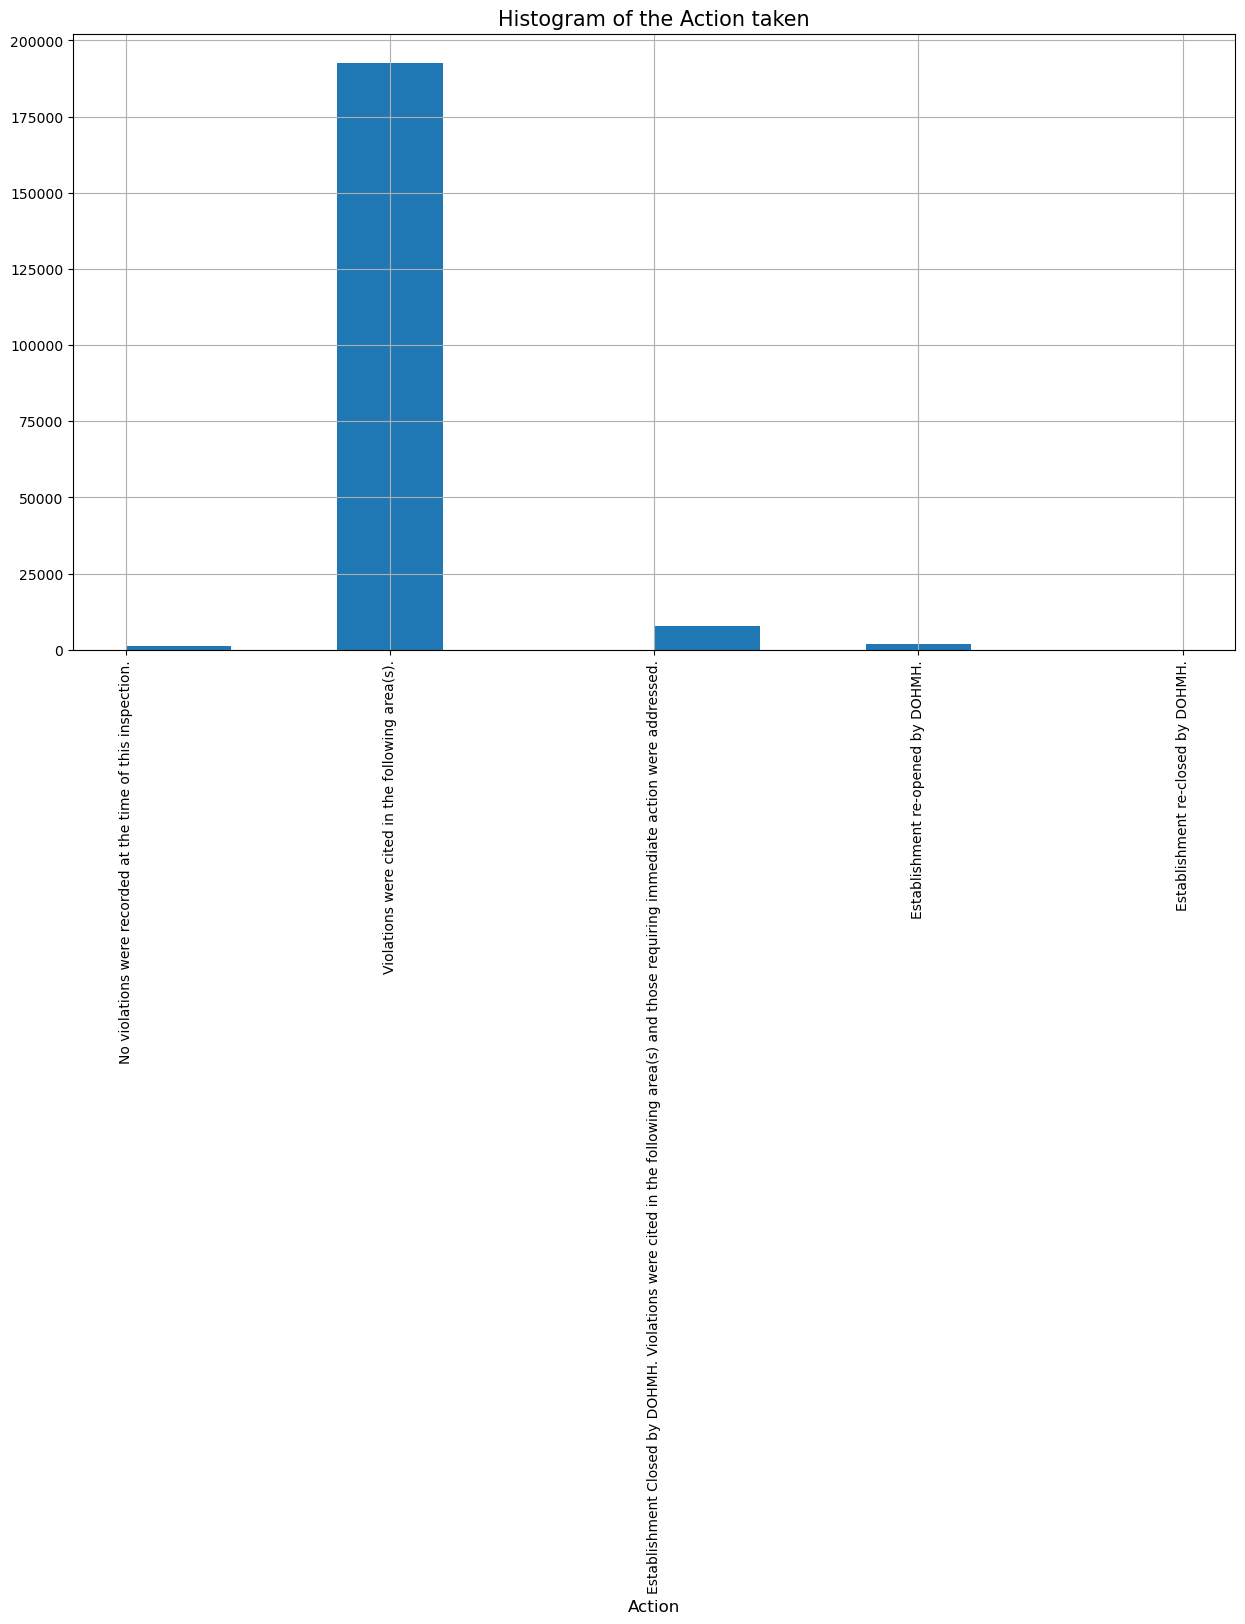

In [32]:
# Histogram of the Action taken
rdf.ACTION.hist(figsize = (15,8))
plt.title('Histogram of the Action taken', fontsize = 15)
plt.xlabel('Action', fontsize = 12)
plt.xticks(rotation=90)

In [33]:
rdf['CRITICAL FLAG'].value_counts()

Critical          112198
Not Critical       88774
Not Applicable      4614
Name: CRITICAL FLAG, dtype: int64

Text(0.5, 0, 'Flag')

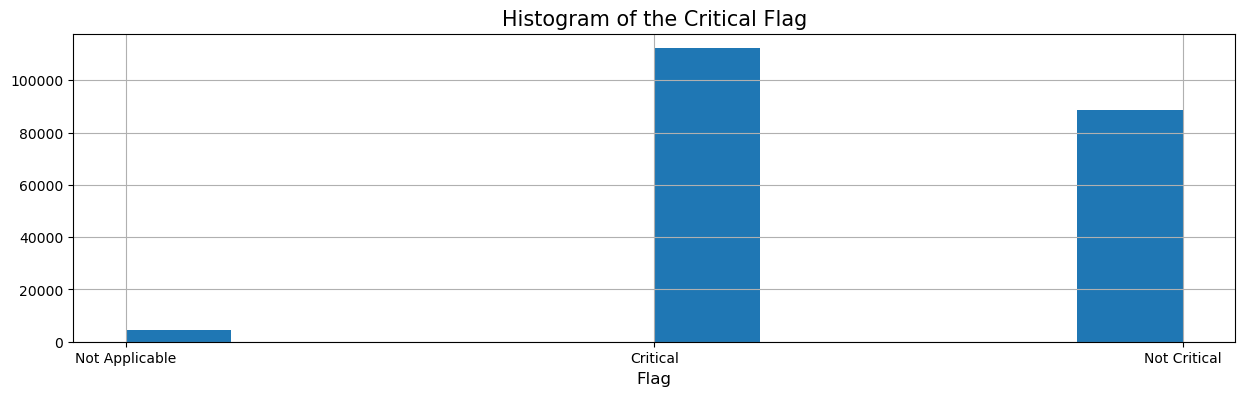

In [34]:
# Graphical representation of the critical flag
rdf['CRITICAL FLAG'].hist(figsize=(15,4))
plt.title('Histogram of the Critical Flag', fontsize = 15)
plt.xlabel('Flag', fontsize = 12)

Text(0.5, 1.0, 'Critical Flag by Borough')

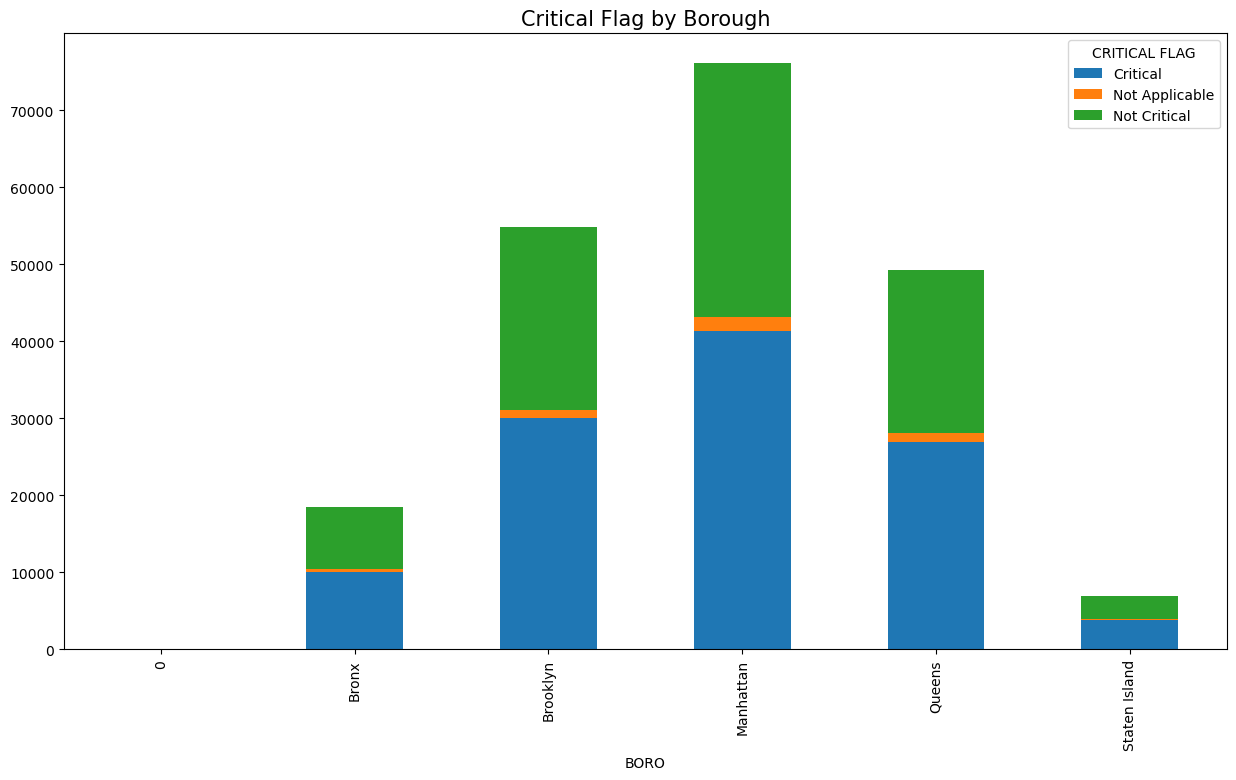

In [35]:
# Critical Flag by Borough
pd.crosstab(rdf.BORO, rdf['CRITICAL FLAG']).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Critical Flag by Borough', fontsize = 15)

Text(0.5, 1.0, 'Critical Flag by Cuisine')

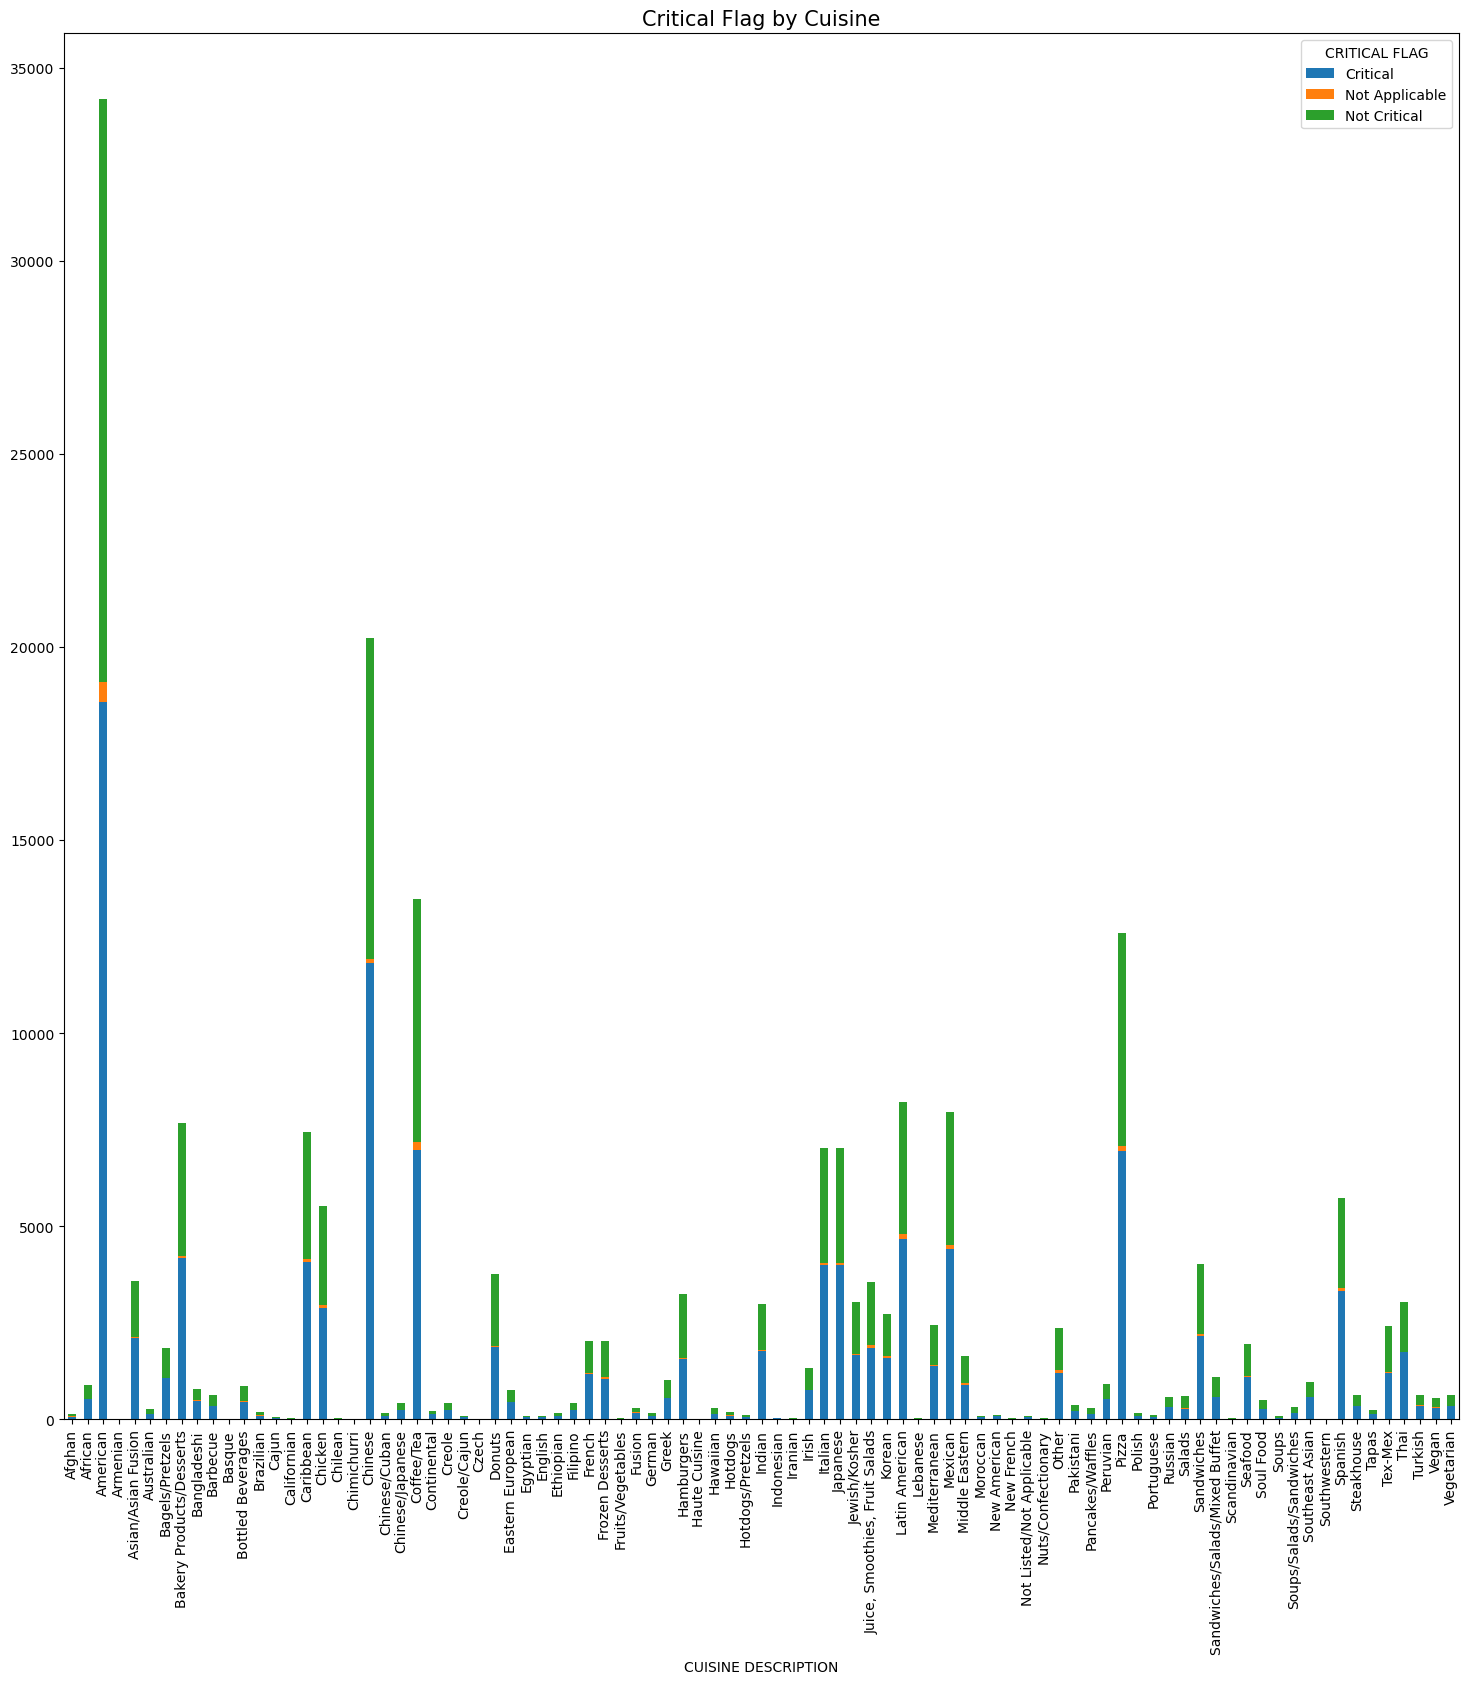

In [36]:
# Critical Flag by Cuisine
pd.crosstab(rdf['CUISINE DESCRIPTION'], rdf['CRITICAL FLAG']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15)

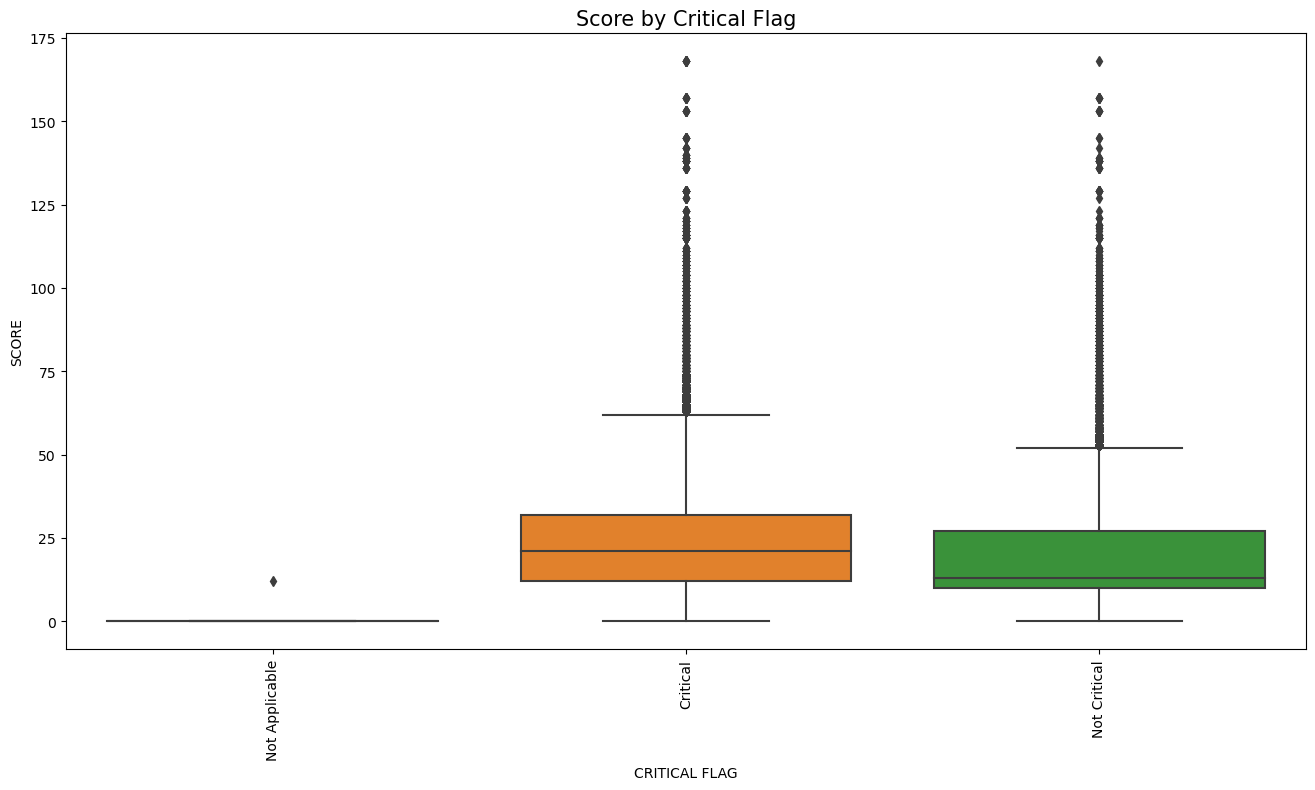

In [37]:
# Let us look at the scores by critical flag
score_flag = pd.concat([rdf['CRITICAL FLAG'], rdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CRITICAL FLAG', y="SCORE", data = score_flag)
plt.title('Score by Critical Flag', fontsize = 15)
plt.xticks(rotation=90);

# **Text Visual**

In [38]:
rdf['VIOLATION DESCRIPTION'].value_counts()

Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.                                                            14974
Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.                                                                                                                                     14006
Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.    13391
Establishment is not free of harborage or conditions conducive to rodents, insects or other pests.                                                           

In [39]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

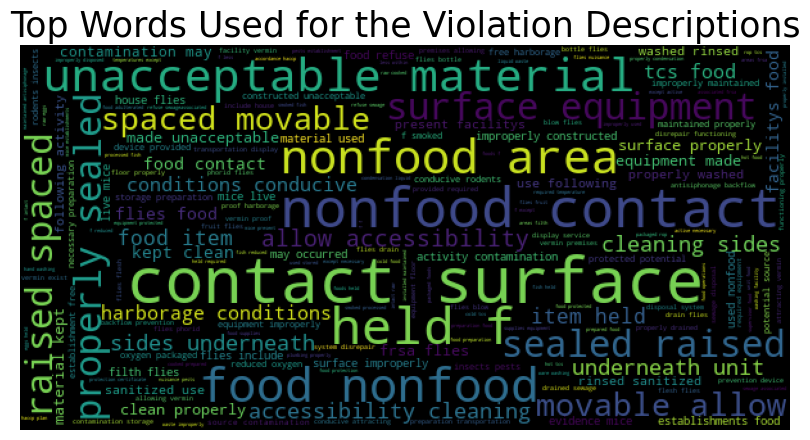

In [40]:
# Let us create a word cloud for the violation description
temp_data = rdf.dropna(subset=['VIOLATION DESCRIPTION'])
# converting into lowercase
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].map(text_prepare)
# Wordcloud visual for most used words for Violation Desriptions
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['VIOLATION DESCRIPTION'].values))
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.title("Top Words Used for the Violation Descriptions", fontsize=25)
plt.axis("off")
plt.show() 